# Vehicle classifier

In this notebook we will build a classifier to detect whether an image contains a car or not, the notebook is organized as belows

 * Exploring dataset
 * Exploring image features such as **HOG**, **binning spatial** and **color histogram**
 * Training classifier with SVM classifier
 
First, let's import some modules

In [1]:
import glob
import os
import time
import numpy as np
import pandas as pd
import cv2
import pickle
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn import pipeline
from sklearn.metrics import accuracy_score, precision_score

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

## Exploring dataset
In this project, we use the labelled data given by Udacity: [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip). 

We load all files' location in to dataframe and dump to csv for later use

In [2]:
def list_imgs(imgdirs, ext = 'png'):
    imgfiles = []
    for imgdir in imgdirs:
        fns = glob.glob('{}/*.{}'.format(imgdir, ext))
        imgfiles += list(np.sort(fns))
    return imgfiles

dataset_csv = 'datas/dataset.csv'
if not os.path.isfile(dataset_csv):
    cars = list_imgs(['datas/vehicles/GTI_Left',
                      'datas/vehicles/GTI_Right'
                      'datas/vehicles/GTI_MiddleClose',
                      'datas/vehicles/GTI_Far',
                      'datas/vehicles/KITTI_extracted'])
    noncars = list_imgs(['datas/non-vehicles/GTI',
                         'datas/non-vehicles/Extras'])
    
    # create pd.DataFrame and save it to csv
    flags = [1]*len(cars) + [0]*len(noncars)
    dataset = pd.DataFrame({'file':cars+noncars, 'is_car':flags})
    dataset.to_csv(dataset_csv, index=False)
else:
    dataset = pd.read_csv(dataset_csv)
    cars = dataset['file'][np.where(dataset['is_car']==1)[0]].values
    noncars = dataset['file'][np.where(dataset['is_car']==0)[0]].values
    
Ncars = len(cars)    
Nnoncars = len(noncars)

print('Number of car samples     {}'.format(Ncars))
print('Number of non-car samples {}'.format(Nnoncars))

Number of car samples     7709
Number of non-car samples 8968


So we have 7709/8968 car vs non-car samples, let's visualize some of our samples

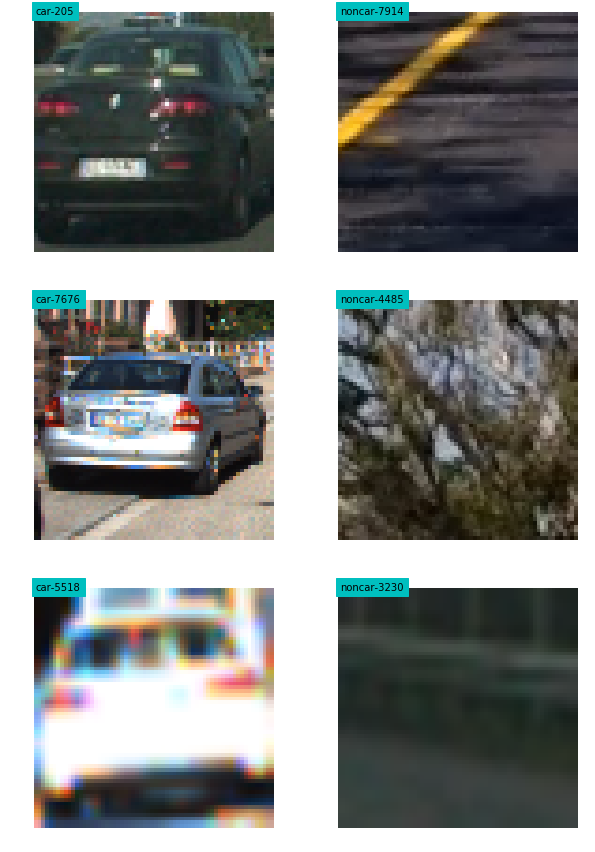

In [3]:
from utils import show_img, view_imgs, grid_view

def visualize_samples(n_samples=3, figsize=(10,15)):
    imgs = []
    labels = []
    for i in range(n_samples):
        icar = np.random.randint(Ncars)
        imgs.append(mpimg.imread(cars[icar]))
        inoncar = np.random.randint(Nnoncars)
        imgs.append(mpimg.imread(noncars[inoncar]))
        labels.extend(['car-{}'.format(icar), 'noncar-{}'.format(inoncar)])
    grid_view(imgs, labels, figsize, nrows=n_samples,ncols=2)

visualize_samples(3)

Looking above image, one can see that some noncar sample actually contains some part of the car.

Note that the training dataset is stored in `png` format and when it read by `mpimg` the input has type `float32` and in range (0., 1.0), the training images has shape `(64,64,3)`

In [4]:
car_img = mpimg.imread(cars[np.random.randint(Ncars)])
noncar_img = mpimg.imread(noncars[np.random.randint(Nnoncars)])

print('Car/non-car input shape {} / {}'.format(car_img.shape, noncar_img.shape))
print('input car/noncar dtype  {} / {}'.format(car_img.dtype, noncar_img.dtype))
print('min/max input           {:.5f} / {:.5f}'.format(np.min(car_img), np.max(car_img)))

Car/non-car input shape (64, 64, 3) / (64, 64, 3)
input car/noncar dtype  float32 / float32
min/max input           0.04314 / 1.00000


## Exploring features
In order to classify an image a car or not a car we need to build features for image, since our image can be taken in any light-condition so we need to select features that is robust to these light condition. As suggested in the project page, one could use

* histograms of color
* spatial binning of color
* hog features

To get a feel for what these features look like, we visualize them for some car/noncar samples.

### Histograms of color
We compute the histogram in each channel then concatenate into a vector, it is implemented in `lesson_utils.get_color_hist`. Now let visualize some car/non-car samples

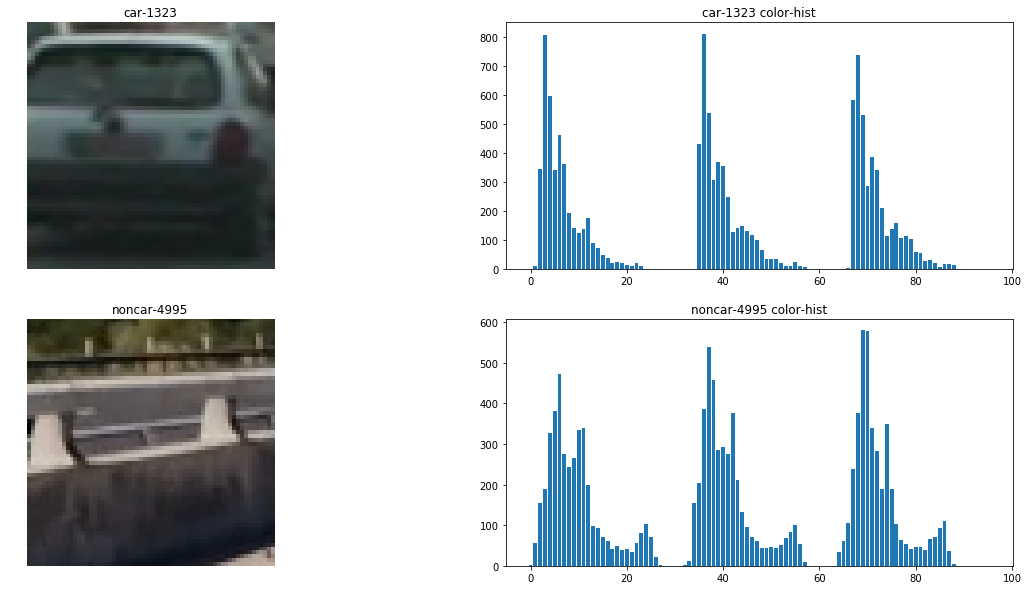

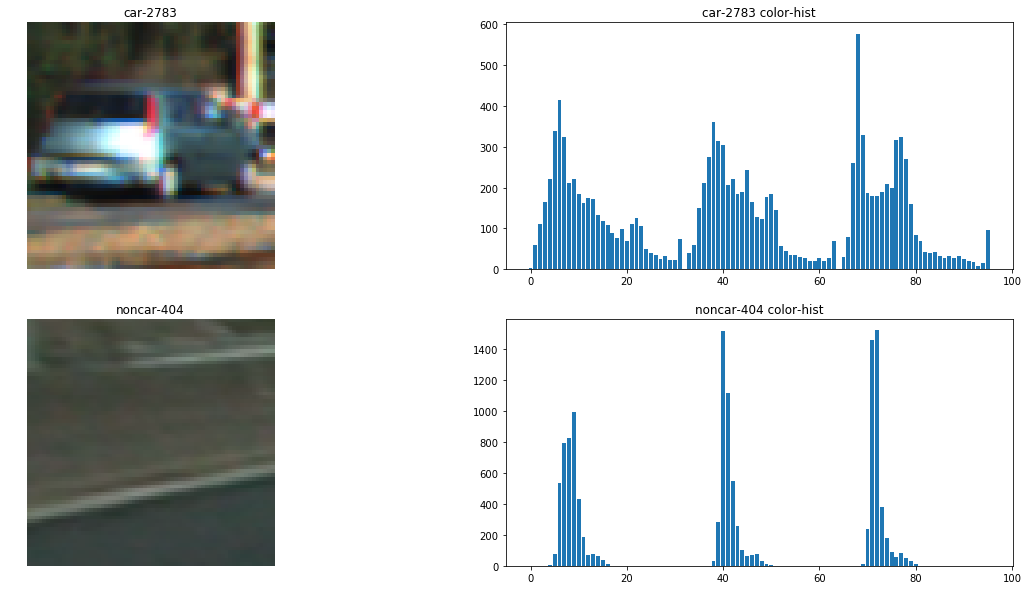

In [5]:
from lesson_utils import read_img, get_color_hist, name2cspace
def visualize_color_hist(icar, inoncar, figsize, **kwargs):
    # car
    img = read_img(cars[icar], kwargs['color_space'])
    color_hist = get_color_hist(img, **kwargs)
    # noncar
    img_nc = read_img(noncars[inoncar], kwargs['color_space'])
    color_hist_nc = get_color_hist(img_nc, **kwargs)
    
    fig, axes = plt.subplots(figsize=figsize, nrows=2, ncols=2, sharey=False, sharex=False)
    ax1, ax2, ax3, ax4 = axes.flatten()
    #
    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title('car-{}'.format(icar))
    ax2.bar(range(len(color_hist)), color_hist)
    ax2.set_title('car-{} color-hist'.format(icar))
    
    ax3.imshow(img_nc)
    ax3.axis('off')
    ax3.set_title('noncar-{}'.format(inoncar))
    ax4.bar(range(len(color_hist)), color_hist_nc)
    ax4.set_title('noncar-{} color-hist'.format(inoncar))

hist_setting = {'color_space': 'RGB',
                'nbins'      : 32,
                'bins_range' : (0.0, 1.0)}    
for i in range(2):
    icar    = np.random.randint(Ncars)    
    inoncar = np.random.randint(Nnoncars)
    visualize_color_hist(icar, inoncar, (20,10),**hist_setting)

Looking at above image, for some case we can distiguish color-hist of car/noncar but for some sample, they look similar. Let's checkout `bin-spatial`. Let's check the color-hist for other color-space, note that in each color-space the range for each channel is different

* HSV/HLS: the H channel has range [0, 360]
* LUV: the L channel's range is [0,100], U 's range is [-134,220] and V's range is [-140,122]
* others has range [0,1]

We verify above range with our input-images

In [6]:
img = mpimg.imread(cars[np.random.randint(Ncars)])
for cspace in ['HSV', 'HLS', 'LUV', 'YUV', 'YCrCb']:
    img_cspace = cv2.cvtColor(img, name2cspace[cspace])
    print('\nIn color-space {}'.format(cspace))
    for c in range(3):
        print('\tmin/max ch({}) is {:7.2f} / {:.2f}'.format(c,
                                                           np.min(img_cspace[:,:,c]), 
                                                           np.max(img_cspace[:,:,c])))    


In color-space HSV
	min/max ch(0) is    0.00 / 355.38
	min/max ch(1) is    0.02 / 0.63
	min/max ch(2) is    0.09 / 0.54

In color-space HLS
	min/max ch(0) is    0.00 / 355.38
	min/max ch(1) is    0.06 / 0.51
	min/max ch(2) is    0.01 / 0.46

In color-space LUV
	min/max ch(0) is    6.28 / 55.96
	min/max ch(1) is  -13.62 / 9.88
	min/max ch(2) is   -8.89 / 9.22

In color-space YUV
	min/max ch(0) is    0.08 / 0.53
	min/max ch(1) is    0.45 / 0.53
	min/max ch(2) is    0.47 / 0.53

In color-space YCrCb
	min/max ch(0) is    0.07 / 0.52
	min/max ch(1) is    0.44 / 0.54
	min/max ch(2) is    0.48 / 0.53


So we need to scale our image before computing the color-histogram (since we fixed the `bins_range=[0,1]`

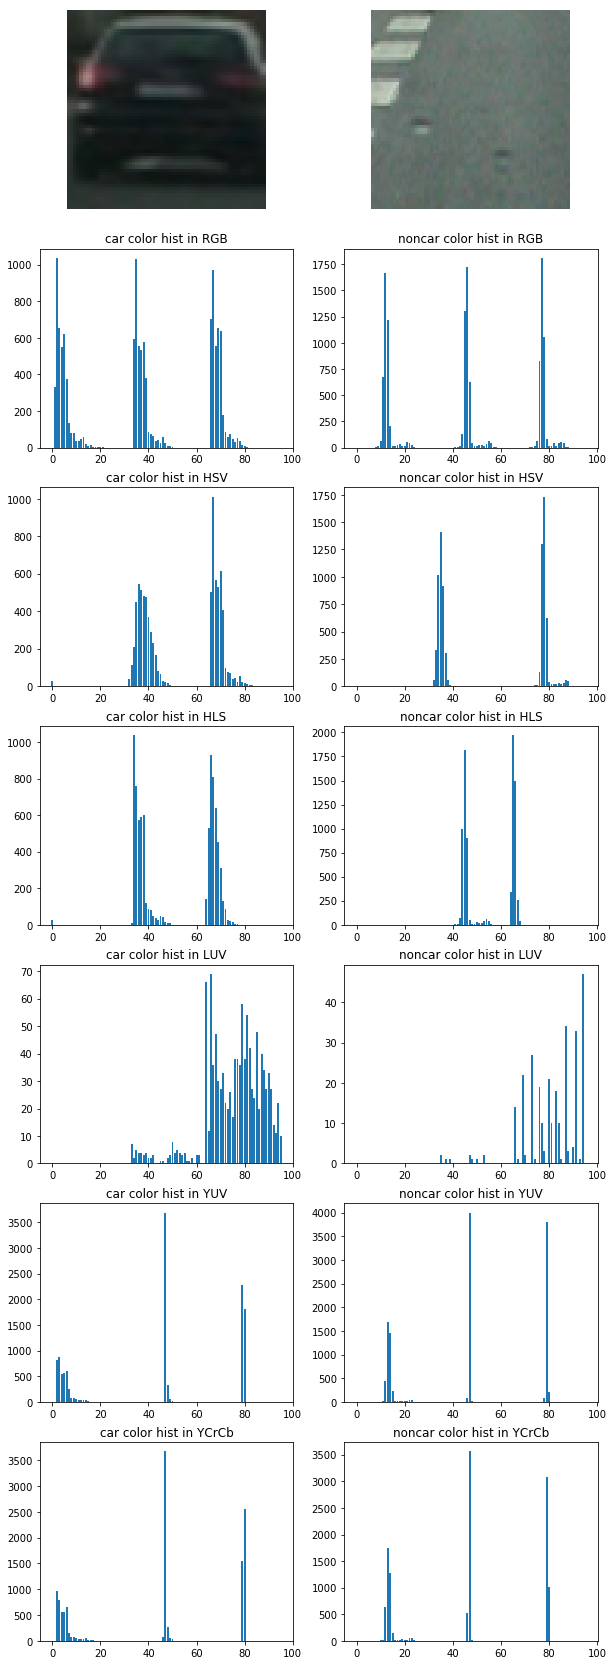

In [7]:
from lesson_utils import scaled_img

def color_hist_cspace(icar, inoncar, figsize, **hist_setting):
    cspaces = ['RGB', 'HSV', 'HLS', 'LUV', 'YUV', 'YCrCb']
    fig, axes = plt.subplots(figsize=figsize, nrows=1+len(cspaces), ncols=2, sharey=False, sharex=False)
    axes = axes.flatten()
    car    = mpimg.imread(cars[icar])
    noncar = mpimg.imread(noncars[inoncar])
    
    imgs = [car, noncar]
    labels = ['car', 'noncar']
    for i in range(2):
        axes[i].imshow(imgs[i])
        axes[i].axis('off')
    
    idx = 2
    for cspace in cspaces:
        for i in range(2):
            img = imgs[i]
            if cspace != 'RGB':
                img = cv2.cvtColor(img, name2cspace[cspace])
                img = scaled_img(img)
            
            color_hist = get_color_hist(img, **hist_setting)
            axes[idx+i].bar(range(len(color_hist)), color_hist)
            axes[idx+i].set_title('{} color hist in {}'.format(labels[i], cspace))
        idx += 2   

color_hist_cspace(np.random.randint(Ncars), np.random.randint(Nnoncars), (10,30))

It's not clear what is the best color-space. Let's try the binning spatical now

### Binning spatial
The original input is 64x64x3, one could resize it to smaller image (until we still recognize object) then contatenate all channel into one vector.

In [8]:
from lesson_utils import convert_img

def visualize_bin_spatial(icar, inoncar, cspace, figsize, spatial_size=(32, 32), scaled=True):
    car = mpimg.imread(cars[icar])
    noncar = mpimg.imread(noncars[inoncar])
    
    car_feats    = cv2.resize(convert_img(car, cspace, scaled), spatial_size)
    noncar_feats = cv2.resize(convert_img(noncar, cspace, scaled), spatial_size)
    
    fig, axes = plt.subplots(figsize=figsize, nrows=2, ncols=4, sharey=False, sharex=False)
    imgs  = [car, car_feats[:,:,0], car_feats[:,:,1], car_feats[:,:,2]]
    imgs += [noncar, noncar_feats[:,:,0], noncar_feats[:,:,1], noncar_feats[:,:,2]]
    labels = ['original', 'channel(0)-{}'.format(cspace), 'channel(1)-{}'.format(cspace), 'channel(2)-{}'.format(cspace)]
    cmaps = [None] + ['gray']*3
    cmaps += cmaps
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(imgs[i], cmap=cmaps[i])
        ax.axis('off')
        if i < 4:
            ax.set_title(labels[i])

icar = np.random.randint(Ncars)
inoncar =  np.random.randint(Nnoncars)

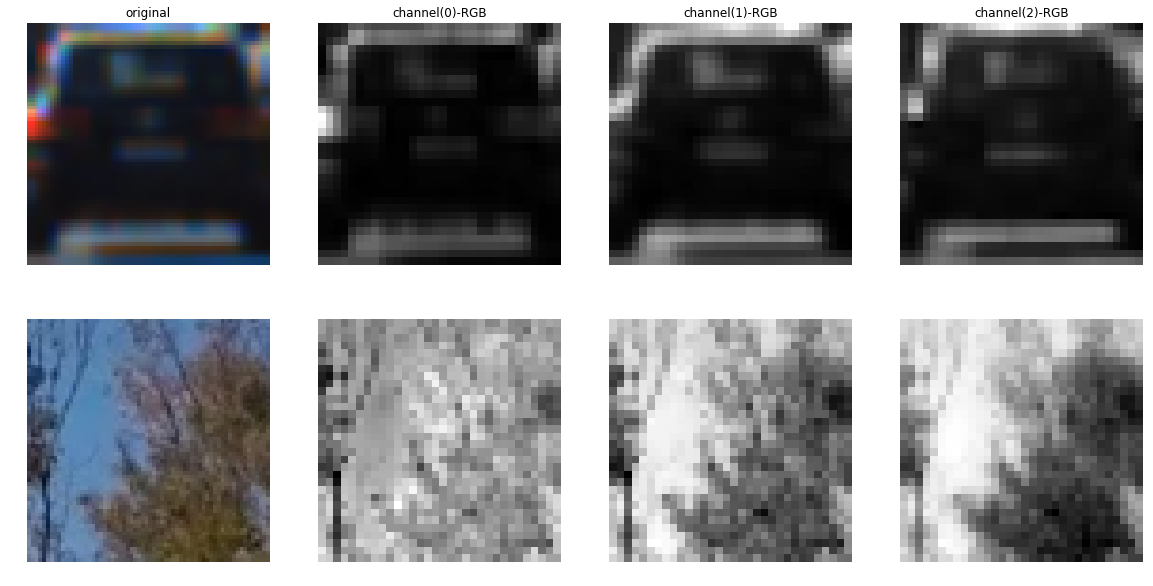

In [9]:
visualize_bin_spatial(icar, inoncar, 'RGB', (20,10))

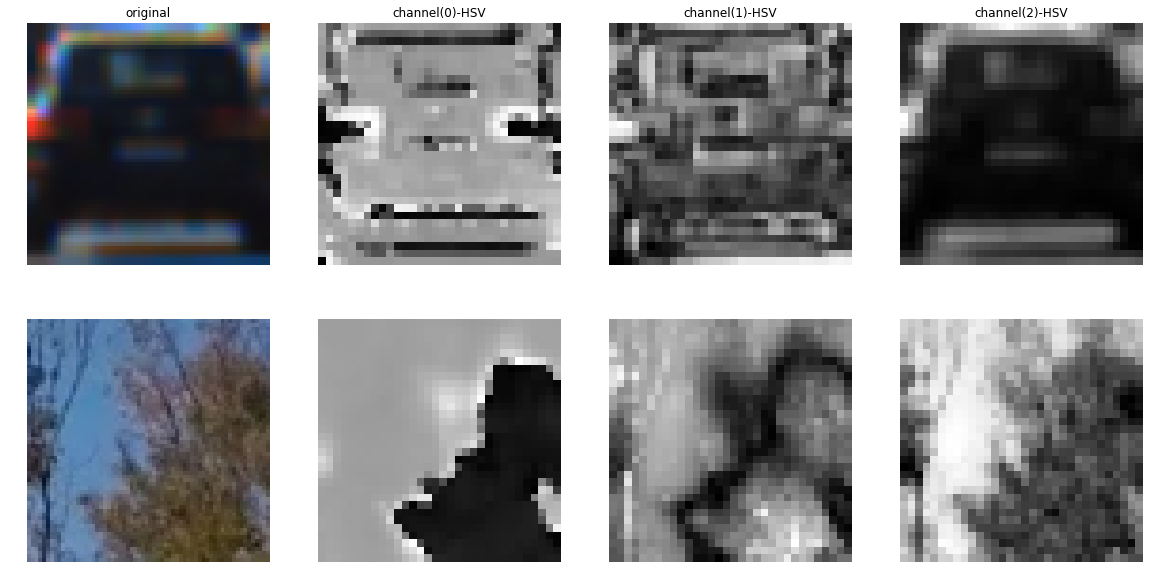

In [10]:
visualize_bin_spatial(icar, inoncar, 'HSV', (20,10))

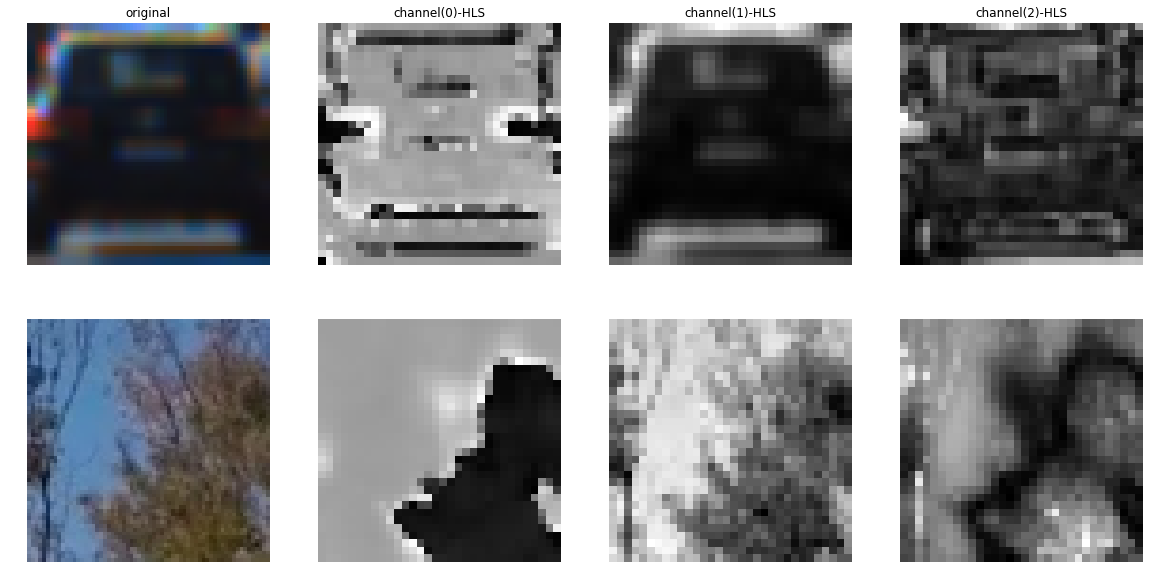

In [11]:
visualize_bin_spatial(icar, inoncar, 'HLS', (20,10))

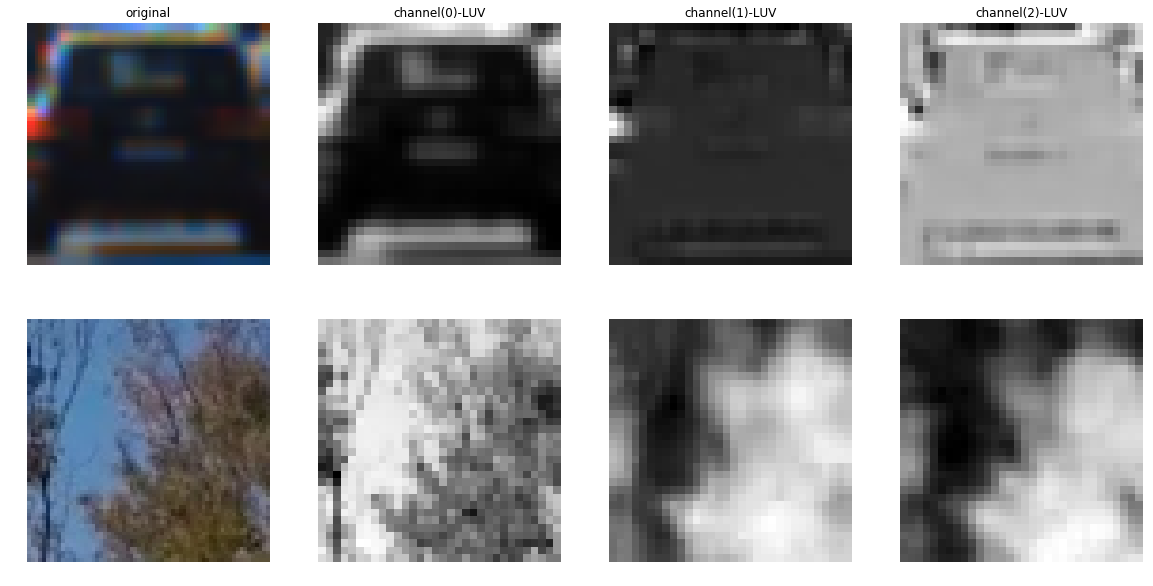

In [12]:
visualize_bin_spatial(icar, inoncar, 'LUV', (20,10))

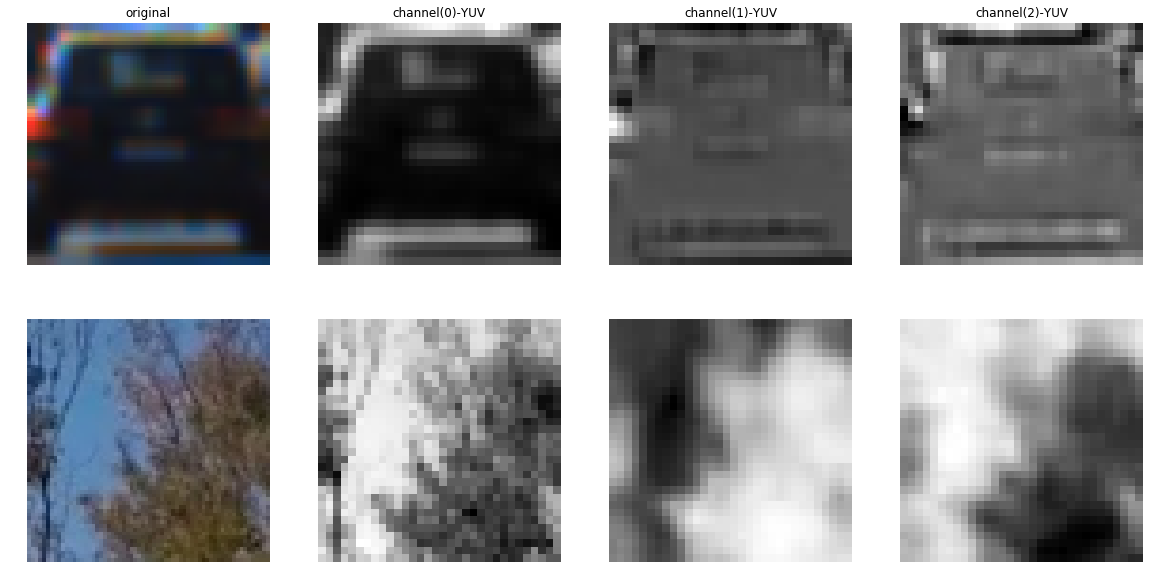

In [13]:
visualize_bin_spatial(icar, inoncar, 'YUV', (20,10))

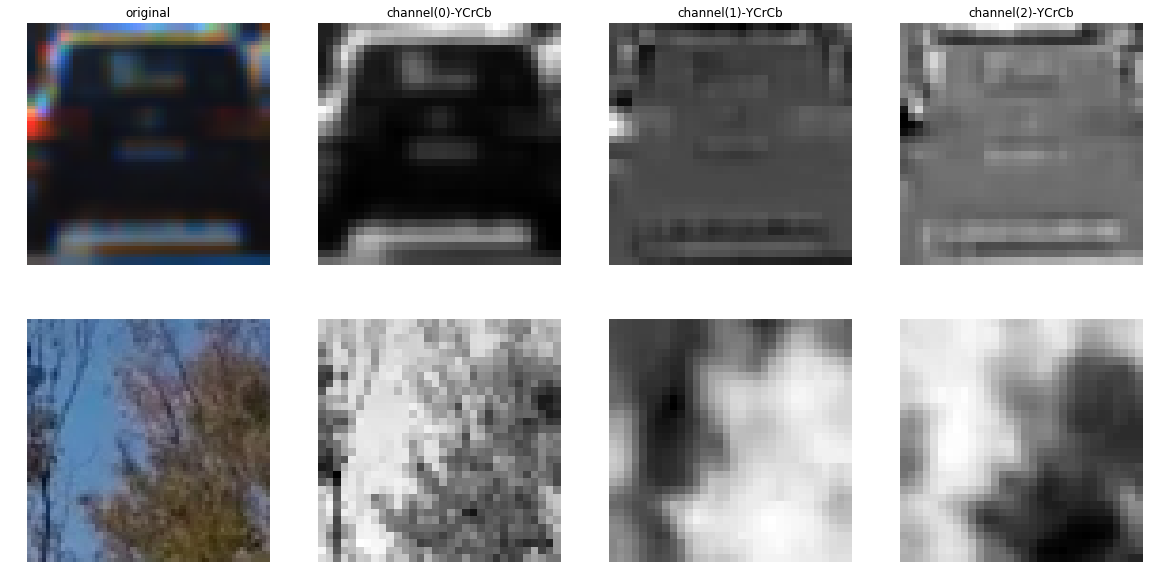

In [14]:
visualize_bin_spatial(icar, inoncar, 'YCrCb', (20,10))

Look at above image, we see that depending on color-space, there is one channel that keeps the shape/constrast info better than these others, for example for `HSV` it's `V`-channel or for `HLS` it's `L`-channel. We will use this info when choosing the channel to compute **HOG feature**.

Note that we should keep `spatial-size=(32,32)` since any value smaller than this the image is too noisy.

### HOG feature
The HOG feature is implemented in the function `lesson_utils.get_hog`, to computing `HOG-feature`, one need to set the following parameters

 * orient: number of orientation bins
 * pix_per_cell: size (in pixels) of a cell
 * cell_per_block: number of cells in each block
 * hog_channel: can be 0, 1, 2 or 'ALL'
 
Let's visualize HOG-features

In [15]:
from lesson_utils import get_hog
def visualize_hog(icar, inoncar, cspace, figsize, scaled=True, **hog_setting):
    car = mpimg.imread(cars[icar])
    noncar = mpimg.imread(noncars[inoncar])
    
    car_cs    = convert_img(car, cspace, scaled)
    noncar_cs = convert_img(noncar, cspace, scaled)
    
    car_hogs = [car]
    noncar_hogs = [noncar]
    labels = ['origal']
    cmaps = [None]
    for i in range(3):
        hog_setting['hog_channel']=i
        _, car_hog = get_hog(car_cs, **hog_setting)
        _, noncar_hog = get_hog(noncar_cs, **hog_setting)
        car_hogs.append(car_hog)
        noncar_hogs.append(noncar_hog)
        labels.append('ch{} HOG-{}'.format(i, cspace))
        cmaps.append('gray')
    labels += labels
    cmaps += cmaps
    
    grid_view(car_hogs + noncar_hogs, labels, figsize, nrows=2, ncols=4, cmaps=cmaps)

hog_setting = {'orient'          : 8,
               'pix_per_cell'    : 8,
               'cell_per_block'  : 2,
               'hog_channel'     : 0,
               'vis'             : True,
               'feature_vec'     : True}

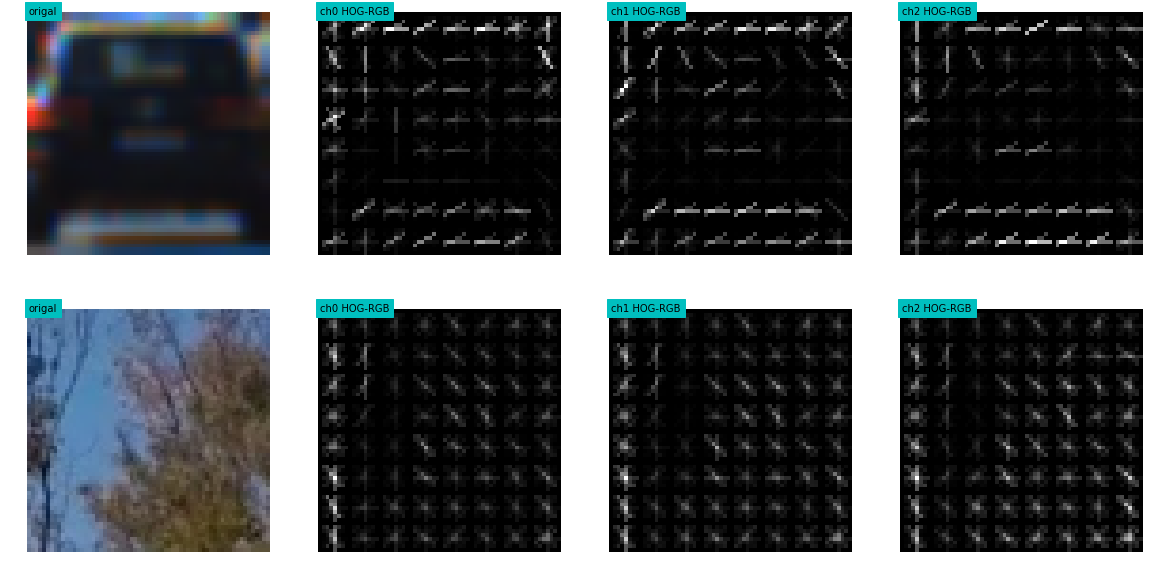

In [16]:
visualize_hog(icar, inoncar, 'RGB', (20,10), **hog_setting)

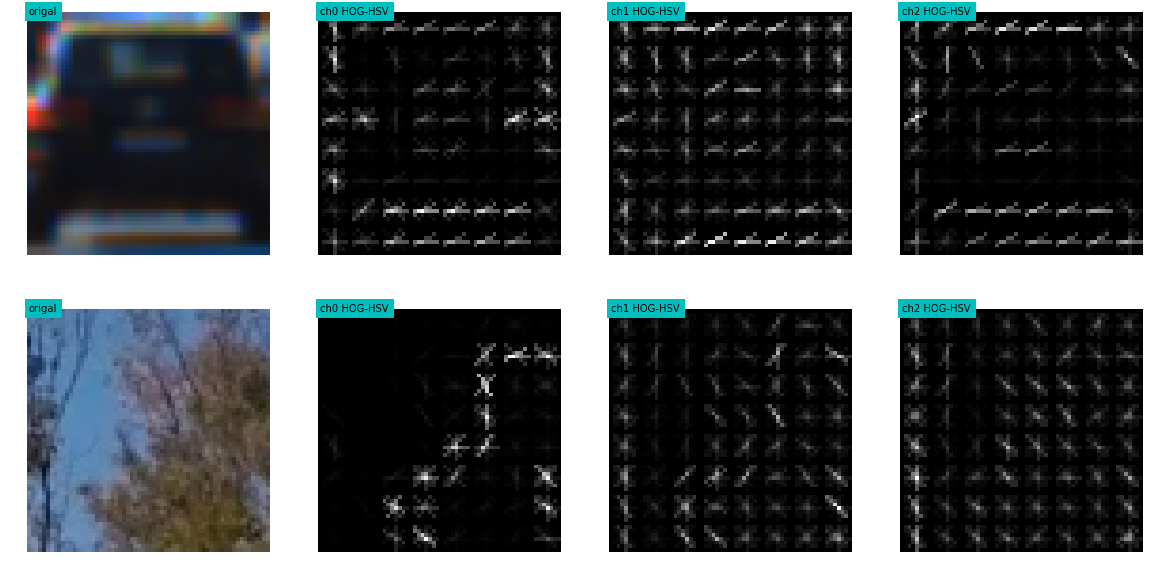

In [17]:
visualize_hog(icar, inoncar, 'HSV', (20,10), **hog_setting)

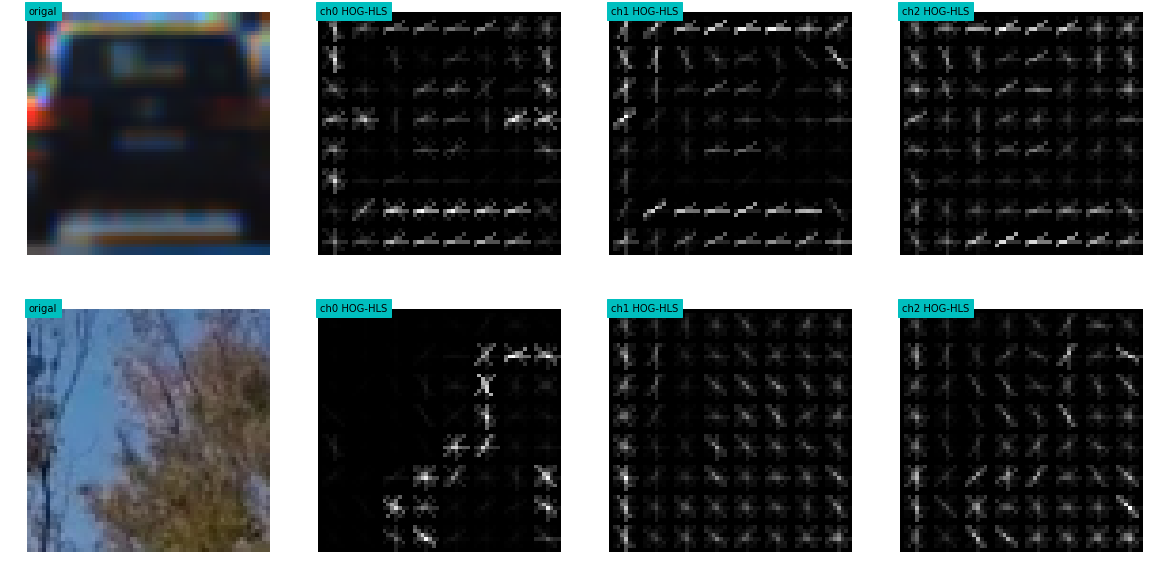

In [18]:
visualize_hog(icar, inoncar, 'HLS', (20,10), **hog_setting)

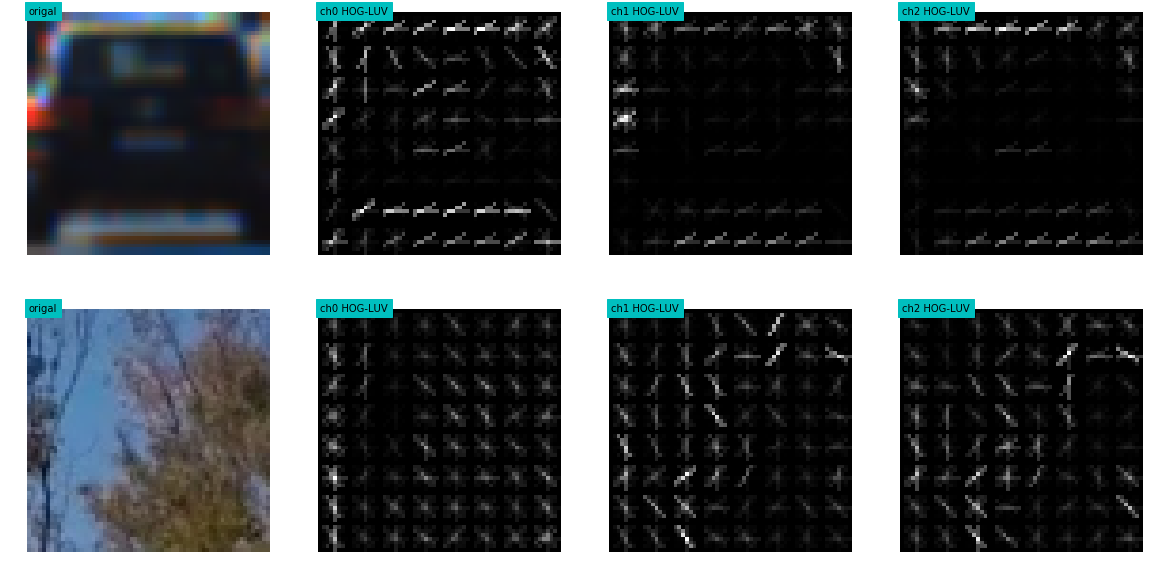

In [19]:
visualize_hog(icar, inoncar, 'LUV', (20,10), **hog_setting)

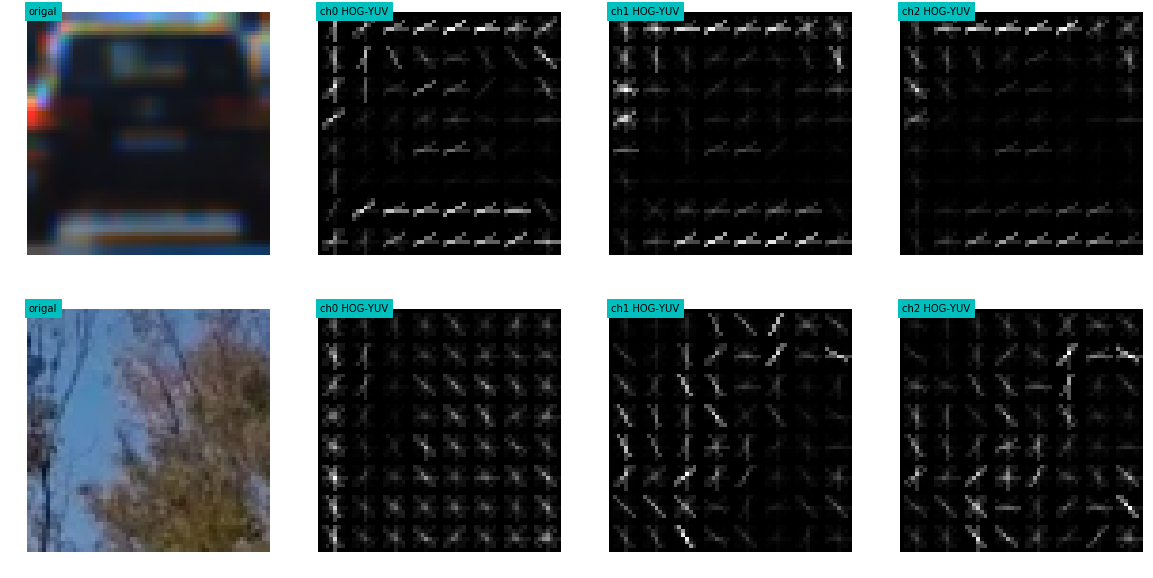

In [20]:
visualize_hog(icar, inoncar, 'YUV', (20,10), **hog_setting)

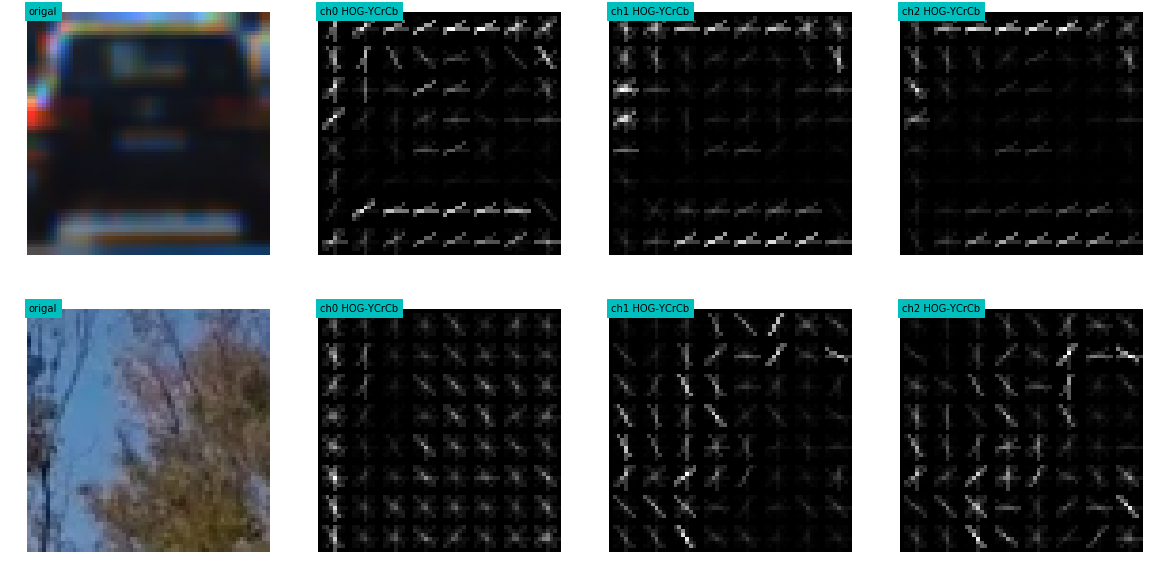

In [21]:
visualize_hog(icar, inoncar, 'YCrCb', (20,10), **hog_setting)

### Combining features
As suggested in the project page, one could use only **HOG-feature** or combine it with **bin-spatial** and/or **color-hist**, this is implemented in `lesson_utils.extract_feature`

In [22]:
hog_setting = {'orient'          : 9,
               'pix_per_cell'    : 8,
               'cell_per_block'  : 2,
               'vis'             : False,
               'feature_vec'     : True}

color_hist_setting = {'hist_bins'  : 32,
                      'bins_range' : (0., 1.)}

bin_spatial_setting = {'spatial_size' : (32, 32)}

combine_setting = {'hog'         : hog_setting,
                   'color_hist'  : color_hist_setting,
                   'bin_spatial' : bin_spatial_setting}

from lesson_utils import extract_features
def build_Xy(dataset, 
             combine_setting, 
             color_space, 
             feats=['hog', 'color_hist', 'bin_spatial'], 
             scaled=True, 
             dump_file=None):
    X, y, feat_settings = extract_features(dataset['file'], 
                                           dataset['is_car'],
                                           combine_setting,
                                           color_space=color_space, 
                                           feats = feats,
                                           scaled=scaled)
    
    # validate if X as NA
    if np.isnan(X).any():
        raise Exception('Got NaN when building Xy for color_space={}. Please check input!!!'.format(color_space))
        
    return X,y, feat_settings

We build feature in different color-spaces so that we train our classifier with different features and select the one that has best validation accuracy

In [23]:
X_HLS, y, fs_HLS = build_Xy(dataset, combine_setting, 'HLS', feats=['hog', 'color_hist', 'bin_spatial'])

Build feature ['hog', 'color_hist', 'bin_spatial'] cost 119.12 second(s)


In [24]:
X_HSV, y, fs_HSV = build_Xy(dataset, combine_setting, 'HSV', feats=['hog', 'color_hist', 'bin_spatial'])

Build feature ['hog', 'color_hist', 'bin_spatial'] cost 96.49 second(s)


In [25]:
X_LUV, y, fs_LUV = build_Xy(dataset, combine_setting, 'LUV', feats=['hog', 'color_hist', 'bin_spatial'])

Build feature ['hog', 'color_hist', 'bin_spatial'] cost 101.93 second(s)


In [26]:
X_YUV, y, fs_YUV = build_Xy(dataset, combine_setting, 'YUV', feats=['hog', 'color_hist', 'bin_spatial'])

Build feature ['hog', 'color_hist', 'bin_spatial'] cost 95.77 second(s)


In [27]:
X_YCrCb, y, fs_YCrCb = build_Xy(dataset, combine_setting, 'YCrCb', feats=['hog', 'color_hist', 'bin_spatial'])

Build feature ['hog', 'color_hist', 'bin_spatial'] cost 95.76 second(s)


## Train our classifier
Now we have the training data, we first split it into training/validation set (using `train_test_split`), we will test it on video-pipeline so we don't use a test set here.

Next, we will use `svm.LinearSVC` as classifier for this task, since we need to normalize input before pass it to the classifier, we will use `Pipeline` as implemented belows

In [28]:
def train_classifier(X, y, C=1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)
    print('--------------------------------------')
    print('Training input shape   {}'.format(X_train.shape))
    print('Validation input shape {}'.format(X_test.shape))
    
    ts = time.time()
    clf = pipeline.Pipeline([('normalization', StandardScaler()),
                             ('classification', LinearSVC(loss='hinge', C=1))])
    clf.fit(X_train, y_train)
    
    print('Training time {:.2f} seconds'.format(time.time() - ts))
    print('Training accuracy    {:.2f}%'.format(100*clf.score(X_train, y_train)))
    pred = clf.predict(X_test)
    val_acc = accuracy_score(pred, y_test)
    print('Validation accuracy  {:.2f}%'.format(100*val_acc))
    print('--------------------------------------\n')
    
    return clf, val_acc

Now let's train with various color-space

In [29]:
print ('Training with HLS')
clf_hls, _ = train_classifier(X_HLS, y)

print ('Training with HSV')
clf_hsv, _ = train_classifier(X_HSV, y)

print ('Training with LUV')
clf_luv, _ = train_classifier(X_LUV, y)

print ('Training with YUV')
clf_yuv, _ = train_classifier(X_YUV, y)

print ('Training with YCrCb')
clf_ycrcb, _ = train_classifier(X_YCrCb, y)

Training with HLS
--------------------------------------
Training input shape   (26683, 4932)
Validation input shape (6671, 4932)
Training time 10.46 seconds
Training accuracy    100.00%
Validation accuracy  99.12%
--------------------------------------

Training with HSV
--------------------------------------
Training input shape   (26683, 4932)
Validation input shape (6671, 4932)
Training time 11.44 seconds
Training accuracy    100.00%
Validation accuracy  99.19%
--------------------------------------

Training with LUV
--------------------------------------
Training input shape   (26683, 4932)
Validation input shape (6671, 4932)
Training time 20.01 seconds
Training accuracy    100.00%
Validation accuracy  98.71%
--------------------------------------

Training with YUV
--------------------------------------
Training input shape   (26683, 4932)
Validation input shape (6671, 4932)
Training time 18.36 seconds
Training accuracy    100.00%
Validation accuracy  98.95%
--------------------

We notice that all color-space performs well ~ 98.5% for validation-accuracy with **HLS** is the best with 98.71%. However we notice that all of them seems overfitting. We can see that the classifier suffers from overfitting, we can tackle it via augmented data/additional data in the future work. Now let's save our trained classifier and see if it works in the context of this project.

## Save trained model
Let's save our best classifier so that we can use it in *Sliding-Windown-Search*

In [30]:
def save_model(clf, fs, fileout):
    trained_model = {'clf' : clf, 'feat_settings' : fs}
    with open(fileout, 'wb') as f:
        pickle.dump(trained_model, f)

save_model(clf_hls,  fs_HLS, 'trained_model_hls.pkl')        
save_model(clf_hsv,  fs_HSV, 'trained_model_hsv.pkl')
save_model(clf_luv,  fs_LUV, 'trained_model_luv.pkl')
save_model(clf_yuv,  fs_YUV, 'trained_model_yuv.pkl')
save_model(clf_ycrcb,  fs_YCrCb, 'trained_model_ycrcb.pkl')